# Assignment 2 Brief 

## Deadline: Tuesday, December 3, 2019 at 14:00 hrs

## Number of marks available: 20

## Scope: Sessions 6 to 9

## 1. Instructions
### How and what to submit

A. Submit a Jupyter Notebook named COM4509-6509_Assignment_2_UCard_XXXXXXXXX.ipynb where XXXXXXXXX refers to your UCard number.

B. Upload the notebook file to MOLE before the deadline above.

C. **NO DATA UPLOAD**: Please do not upload the data files used. We have a copy already. 


### Assessment Criteria 

* Being able to manipulate a dataset by generating sythetic data and extracting a particular subset. 

* Being able to build and train different machine learning models with tunable hyperparameters to optimise given evaluation metric.

* Being able to compare different machine learning models and explain interesting results observed. 

* Being able to follow examples in the lab and write code without the help of starter code.


### Late submissions

We follow Department's guidelines about late submissions, i.e., a deduction of 5% of the mark each working day the work is late after the deadline. NO late submission will be marked one week after the deadline because we will release a solution by then. Please read [this link](https://sites.google.com/sheffield.ac.uk/compgtstudenthandbook/menu/assessment/late-submission?pli=1&authuser=1). 

### Use of unfair means 

**"Any form of unfair means is treated as a serious academic offence and action may be taken under the Discipline Regulations."** (from the MSc Handbook). Please carefully read [this link](https://sites.google.com/sheffield.ac.uk/compgtstudenthandbook/menu/referencing-unfair-means?pli=1&authuser=1) on what constitutes Unfair Means if not sure.

# 2. Image classification and denoising

### The CIFAR-10 dataset
In this assignment, we will work on the [**CIFAR-10 dataset**](https://www.cs.toronto.edu/~kriz/cifar.html) collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton from the University of Toronto.  This dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. Each image is a 3-channel colour images of 32x32 pixels in size. There are 50000 training images and 10000 test images. 

			
### Question 1: Data loading and manipulation (4 marks)

1a. **Download** both the training and test data of the CIFAR-10 dataset, e.g., by following the [pytorch CIFAR10 tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). You can also download via other ways if you prefer.

1b. **Add random noise** to all training and test data to generate noisy dataset, e.g., by `torch.randn()`, with a scaling  factor `scale`, e.g., original image `+ scale * torch.randn()`, and **normalise/standardise** the pixel values to the **original range**, e.g.,  using `np.clip()`. You may choose any `scale` value between 0.2 and 0.5. 

**Note: Before generating the random noise, you MUST set the random seed to your UCard number XXXXXXXXX for reproducibility, e.g., using `torch.manual_seed()`. This seed needs to be used for all remaining code if there is randomness, for reproducibility.**

1c. **Extract a subset** with only two classes: **Cat** and **Dog** and name it starting with **CatDog**.        

1d. Show 10 pairs of original and noisy images of cats and 10 pairs of original and noisy images of dogs.

#### Question 1 Answer

In [1]:
# Imports
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# Initialise random seeds:
np.random.seed(160152997)
torch.manual_seed(160152997)

### Question 1a

In [3]:
# Download CIFAR10 dataset
train_set_obj = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
test_set_obj = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

# Extract data as np.array
train_set = train_set_obj.data/255 # Get into 0..1 range RGB values
test_set = test_set_obj.data/255

Files already downloaded and verified
Files already downloaded and verified


### Question 1b

In [4]:
def normalise(data, mean, std, reverse=False):
    """ Noramlise the data to 0 mean and 1 std
        Can also reverse the normalisation process

    Parameters
    ----------
    data
        np.array to be normalised
    mean
        mean of the training data 
    std
        standard deviation of the training data
    reverse : optional
        if passed unnomralises the data

    Returns
    -------
    norm_data
        normalised data

    """
    if reverse:
        norm_data = (data*std) + mean
    else:
        norm_data = (data - mean)/std
    return norm_data

def add_noise(data, noise_scale):
    noisy_data = data + (np.random.standard_normal(data.shape) * noise_scale)
    return noisy_data

In [5]:
# Normalise the data
train_mean = train_set.mean()
train_std = train_set.std()

train_norm = normalise(train_set, train_mean, train_std)
test_norm = normalise(test_set, train_mean, train_std)

# Add some noise to the data
noise_scale = 0.5
train_noisy = add_noise(train_norm, noise_scale)
test_noisy = add_noise(test_norm, noise_scale)

### Questions 1c

In [6]:
def get_classes(data, data_obj, class_names):
    """ Extracts given classes form CIFAR10 dataset

    Parameters
    ----------
    data
        np.array of CIFAR10 data
    data_obj
        CIFAR10 data object
    class_names
        names of classes to be extracted

    Returns
    -------
    class_data, class_targets
        data with only the given class and coresponding labels

    """
    classes = data_obj.class_to_idx
    class_labels = list(map(classes.get, class_names))
    
    targets = np.array(data_obj.targets)
    intersection = np.zeros(targets.shape[0], dtype=bool)
    
    for label in class_labels:
        intersection = np.logical_or(intersection, (targets == label))
    
    class_data = data[intersection]
    class_targets = targets[intersection]
    
    return class_data, class_targets

cat_dog = ['cat', 'dog']

CatDog_train, CatDog_train_targ = get_classes(train_norm, train_set_obj, cat_dog)
CatDog_test, CatDog_test_targ = get_classes(test_norm, test_set_obj, cat_dog)

CatDog_train_noisy, _ = get_classes(train_noisy, train_set_obj, cat_dog)
CatDog_test_noisy, _ = get_classes(test_noisy, test_set_obj, cat_dog)

### Question 1d

D:\Anaconda\envs\MLAI\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


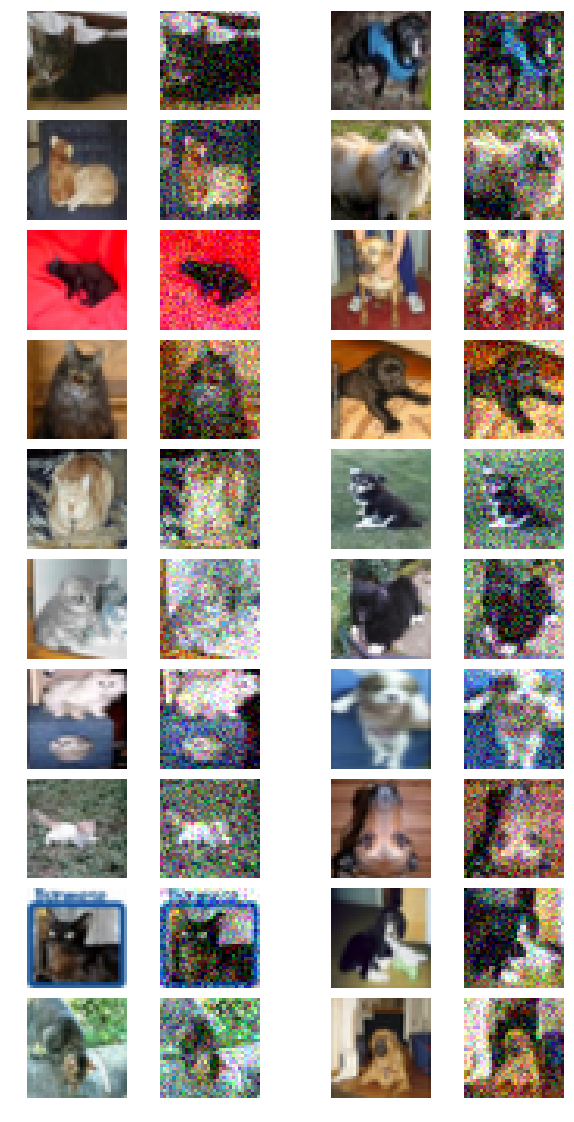

In [7]:
n_examples = 10

cat_examples = np.where(CatDog_train_targ == train_set_obj.class_to_idx['cat'])[0][:n_examples]
dog_examples = np.where(CatDog_train_targ == train_set_obj.class_to_idx['dog'])[0][:n_examples]
all_examples = (cat_examples, dog_examples)

fig = plt.figure(figsize = (10, 20))
outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.1)

for i in range(2):
    inner = gridspec.GridSpecFromSubplotSpec(n_examples, 2,
                    subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    
    img_count = 0
    for j in range(0, n_examples*2, 2):
        clear_ax = plt.Subplot(fig, inner[j])
        noisy_ax = plt.Subplot(fig, inner[j+1])
        
        clear_ax.set_axis_off()
        noisy_ax.set_axis_off()
        
        clear_img = CatDog_train[all_examples[i][img_count]]
        noisy_img = CatDog_train_noisy[all_examples[i][img_count]]
        
        clear_ax.imshow(np.clip((clear_img*train_std) + train_mean, 0, 1))
        noisy_ax.imshow(np.clip((noisy_img*train_std) + train_mean, 0, 1))
        
        fig.add_subplot(clear_ax)
        fig.add_subplot(noisy_ax)
        
        img_count+=1

fig.show()

### Question 2: Dimensionality reduction, binary classification, and evaluation (6 marks)

This question uses the **CatDog** subset **with no noise added**.

#### Training

2a. Apply PCA on the training set to reduce the dimensionality. You need to study **at least seven** different values ($k_1, k_2, ..., k_7$) for the reduced dimensionality. **Explain** your choice.

2b. Train **eight** Naive Bayes Classifiers (NBC): one on the original features (raw pixels), and seven on PCA features with seven different dimensions in 2a, i.e., NBC on $k_1$ PCA features; NBC on $k_2$ PCA features; ..., NBC on $k_7$ PCA features. You will need to decide on what Naive Bayes classifier (Gaussian? Multinomial? etc.) to use and **explain** your choice.

#### Testing and evaluation
2c. Evalaute the eight Naive Bayes classifiers on the test set in terms of **classification accuracy** and **visualise** their performance using a bar graph.

2d. Plot the [ROC Curves](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) in true positive rates vs false positive rates for the eight Naive Bayes classifiers in **one figure** using eight different line/marker styles clearly labelled. 

2e. Compute the [area under the ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) values for the eight Naive Bayes classifiers and visualise using a bar graph.

2f. Describe **at least three** interesting observations from the evaluation results above. Each observation should have **3-5 sentences**. 


### Question 2a

In [8]:
def flatten_images(images):
    flat_images = images.reshape(images.shape[0], -1)
    return flat_images

In [9]:
def plot_explained_var(var_ratio, k_s):
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Plot 'exaplined variance ration'
    ax[0].plot(var_ratio)
    ax[0].set_xlabel('PCA Components (k)')
    ax[0].set_ylabel('Explained Variance Ratio')
    ax[0].set_title('Variance Ratio for k PCA components')
    ax[0].scatter(k_s, var_ratio[k_s], s=80, facecolors='none', edgecolors='r')

    # Plot cumulative variance ratio
    cumulative_ratio = np.cumsum(var_ratio)
    ax[1].plot(cumulative_ratio)
    ax[1].set_xlabel('PCA Components (k)')
    ax[1].set_ylabel('Cumulative Explained Ratio')
    ax[1].set_title('Cumulative Variance Ratio')
    ax[1].scatter(k_s, cumulative_ratio[k_s], s=80, facecolors='none', edgecolors='r')

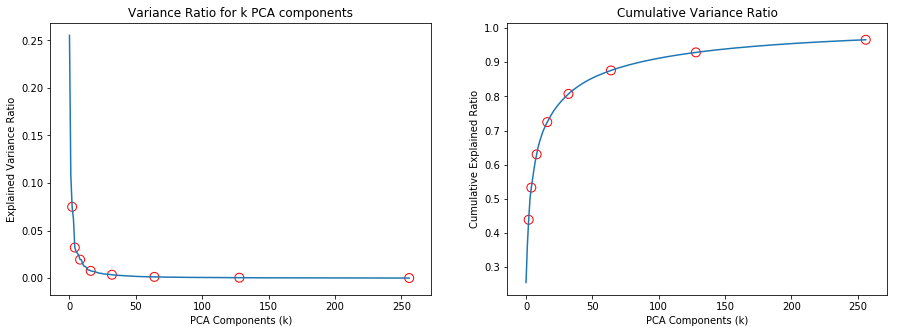

In [10]:
k_s = 2**np.arange(1, 9)

CatDog_pca = PCA(n_components=(k_s[-1]+1), svd_solver='randomized').fit(flatten_images(CatDog_train))
var_ratio = CatDog_pca.explained_variance_ratio_

plot_explained_var(var_ratio, k_s)

#### Question 2a Explanation:

With this set up there is a good concentraion of k's at the 'elbow' of above variance ratio plot. However as can be seen from cumulative variacne plot, all the values at the 'elbow' still have a relatively low cumulative variance of under 75. Therefore it is also imporant to test those values further down the range. Also, who doesn't like the powers of 2?

### Question 2b

#### Which Distribution to Use?
We should obviously use a Gausian Naive Bayes classifier since Multinomial would not be appropriate as the pixel values are continius and don't represent a count.

In [11]:
def evaluate_clf(train_data, test_data, pca_components, clf=GaussianNB()):
    
    """ Evaluate a sklearn classifier

    Parameters
    ----------
    train_data
        a tuple of (input, output) train pairs
    test_data
        a tuple of (input, output) test pairs
    pca_components
        number of components for PCA
    clf
        an sklearn instance of a classifier

    Returns
    -------
    acc - tuple of (train test) accuracies
    roc - tuple for test roc curve coresponding to (false positive, true positive)
    roc_auc - test area under a curve value
    times - tuple of (train, test) times 
    cm - confusion matrix for the test set

    """
    
    
    train_in, train_targ = train_data
    test_in, test_targ = test_data
    
    start_train = time.time()
    
    # Perform pca
    if pca_components:
        pca = PCA(n_components=pca_components, svd_solver='randomized').fit(train_in)
        train_in = pca.transform(train_in)
        test_in = pca.transform(test_in)
    
    # Train the classifier
    fit_clf = clf.fit(train_in, train_targ)
    train_time = time.time() - start_train
    
    # Training and test accuracy scores
    train_out = fit_clf.predict(train_in)
    train_acc = calc_accuracy(train_out, train_targ)
    
    start_pred = time.time()
    test_out = fit_clf.predict(test_in)
    pred_time = time.time() - start_pred  
    test_acc = calc_accuracy(test_out, test_targ)
    
    # Confusion matrix:
    cm = metrics.confusion_matrix(test_targ, test_out)
     
    # ROC Curve and ROC AUC score:
    try:
        fpr, tpr, _ = metrics.roc_curve(test_targ, fit_clf.predict_proba(test_in)[:, 1], test_targ[0])
        roc_auc = np.round(metrics.roc_auc_score(test_targ, test_out), 3)
    except:
        fpr = tpr = roc_auc = None
    
    acc = (train_acc, test_acc)
    roc = (tpr, fpr)
    times = (train_time, pred_time)
    
    return acc, roc, roc_auc, times, cm

def calc_accuracy(pred, targ):
    
    n_samples = targ.shape[0]
    accuracy = ((pred == targ).sum() / n_samples) * 100
    
    return np.round(accuracy, 3)

### Question 2c

In [12]:
train = (flatten_images(CatDog_train), CatDog_train_targ)
test = (flatten_images(CatDog_test), CatDog_test_targ)

k_s_9 = np.append(k_s, None)

accuracy = []
roc_curve = []
roc_auc = []

for k in k_s_9:
    acc, roc, auc, _, _ = evaluate_clf(train, test, k)
    accuracy.append(acc)
    roc_curve.append(roc)
    roc_auc.append(auc)

#### Displaying Results:

In [13]:
def bar_plot(data, ticks, labels=None, bar_width=0.3, title='', xlabel='', ylabel=''):
    
    x = np.arange(len(ticks)) 

    fig, ax = plt.subplots(figsize=(15,7))
    
    rects = []
    if len(data) == 1:
        rects.append(ax.bar(x, data[0], bar_width))
    else:
        rects.append(ax.bar(x - bar_width/2, data[0], bar_width, label=labels[0]))
        rects.append(ax.bar(x + bar_width/2, data[1], bar_width, label=labels[1]))

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(ticks)
    
    if labels:
        ax.legend()
    
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
            
    for rect in rects:
        autolabel(rect)

    fig.tight_layout()

    
def display_results(accuracy, k_s):
    
    accuracy = np.array(accuracy)
    train_acc = accuracy[:, 0]
    test_acc = accuracy[:, 1]
    
    max_test = np.max(test_acc)
    max_label = k_s[np.argmax(test_acc)]
    
    avr_train = np.average(train_acc)
    avr_test = np.average(test_acc)
    
    print(f'Maximum test accuracy of {max_test}% was achived for {max_label}')
    print(f'Average train accuracy is {avr_train:.3}%')
    print(f'Average test accuracy is {avr_test:.3}%')
    
    if not k_s[-1]:
        k_s[-1] = 'No PCA'
        
    bar_plot([accuracy[:,0], accuracy[:,1]], k_s, labels=['Train Accuracy', 'Test Accuracy'],
            title='Classification Accuracy', xlabel='Approach', ylabel='Accuracy (%)')

Maximum test accuracy of 61.85% was achived for 32
Average train accuracy is 59.4%
Average test accuracy is 58.5%


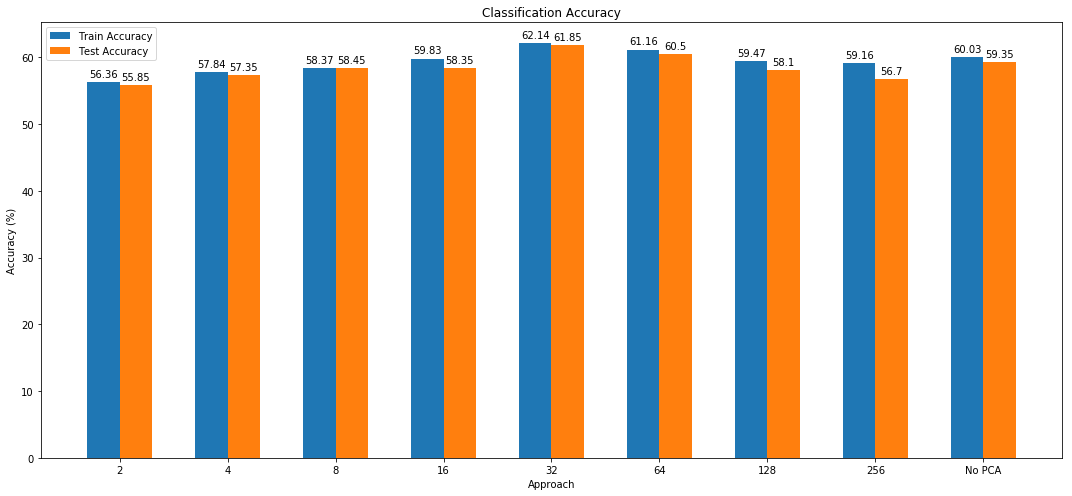

In [14]:
display_results(accuracy, k_s_9)

### Question 2d and 2e

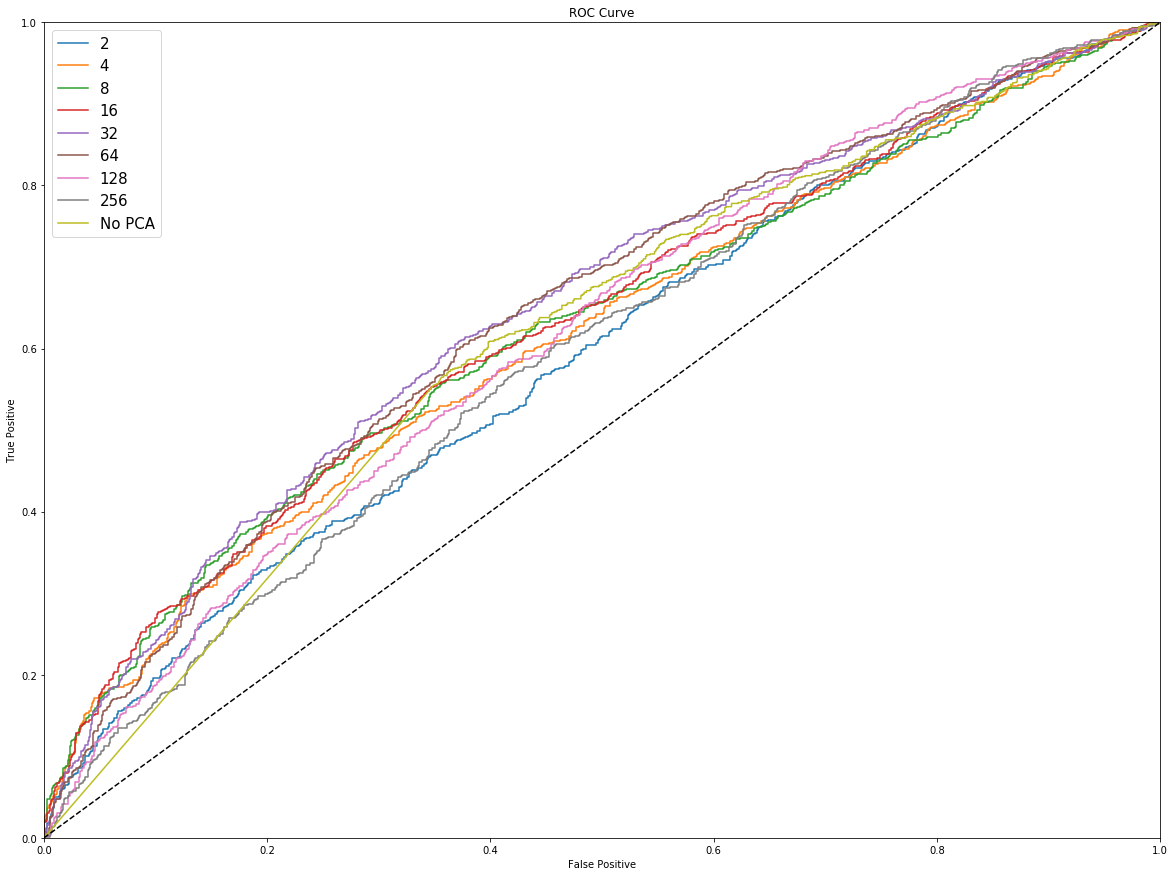

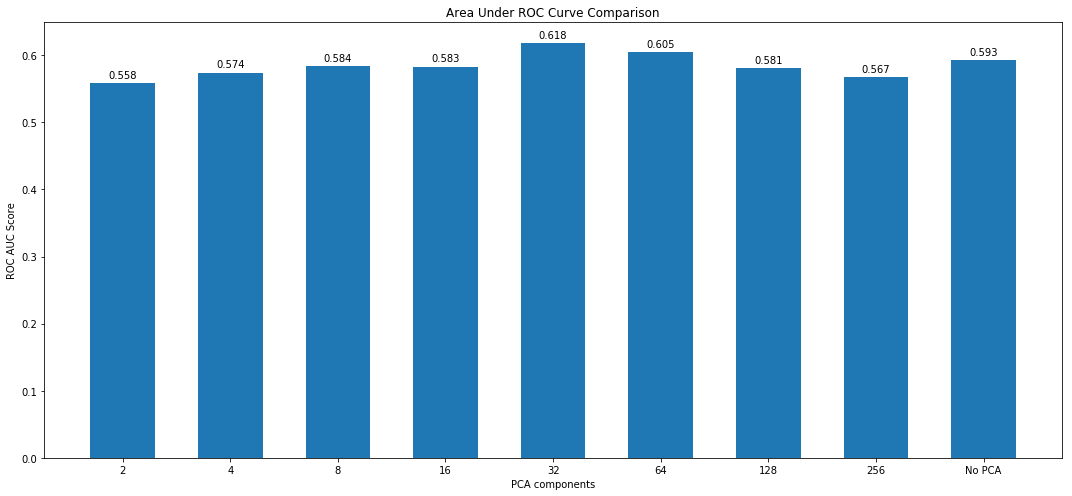

In [15]:
# Plot the ROC curve and Aread Under Curver (AOC)
fig, ax = plt.subplots(figsize=(20,15))

for roc in roc_curve:
    ax.plot(roc[0], roc[1])

ax.set_ylabel('True Positive')
ax.set_xlabel('False Positive')
ax.set_title('ROC Curve')
ax.legend(k_s_9, prop={'size': 15})
ax.plot([0, 1], [0, 1], 'k--')
ax.autoscale(enable=True, tight=True)

bar_plot([roc_auc], k_s_9, bar_width=0.6, title='Area Under ROC Curve Comparison', xlabel='PCA components',
        ylabel='ROC AUC Score')

### Question 2f

1. Test classification accuracy was the highest for 32 pricinpal components with 61.2% confirming the observation above that the 'elbow' of variance ratio plot was not a reliable way to pick number of PCA's. Accuracy gradually increases as we increase the number of components up to 32 and then starts to gradually decrease. This suggests that beyond 32 components the encoded inforamtion in unessesary and could be causing 'curse of dimensionality'. However, interestingly the accuracy for full range of features is slightly higher than for 256pca components suggesting that there is still some key relationship in data that PCA is not able to encode.

2. The ROC curve is quite noisy but again confirms that 32 and 64 PCA components is the more optimal classifiers as they are located closer to the optimal top left. The are under the ROC curve corresponds to the test accuracies obtained above and doesn't really provide any new information.

3. There is no clear sign of overfitting in the training process except for a small trend where overfitting slightly increases as we increase the Number of PCA components from 64 to 256. Again, for No PCA there is no sign of overfitting so this trend could be just noise and would have to be tested for a full range of PCA components. Overfiting at high number of PCA components could be happening because of the higher amount of noise in the data.

### Question 3: Noisy data and multiclass classification (6 marks)

#### Noisy **CatDog** subset.

3a. Repeat 2a, 2b, and 2c on the noisy version of CatDog subset. Show the bar graph and compare it with that in 2c above. 

#### Multiclass classification using the original CIFAR-10 dataset (all 10 classes)

3b. Apply PCA on the training set to reduce the dimensionality. You need to study at least **three** different values for the reduced dimensionality. Explain your choice.

3c. Train nine classifers: **four Naive Bayes** classifiers(one on the original features, and three on PCA features with three different dimensions in 3b); **four Logistic Regression** classifiers (one on the original features, and three on PCA features with three different dimensions in 3b); and one **Convoluational Neural Network** as defined in the [pytorch CIFAR10 tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

3d. Evalaute the nine classifiers on the test set. Summarise the **classification accuracy**, **total training time**, and **total test time** using three bar graphs.

3e. Show the confusion matrix for these nine classifiers (see Lab 8 - 1.4).

3f. Describe **at least three** interesting observations from the evaluation results above. Each observation should have **3-5 sentences**. 

### Question 3a

Maximum test accuracy of 61.1% was achived for 32
Average train accuracy is 59.6%
Average test accuracy is 58.6%


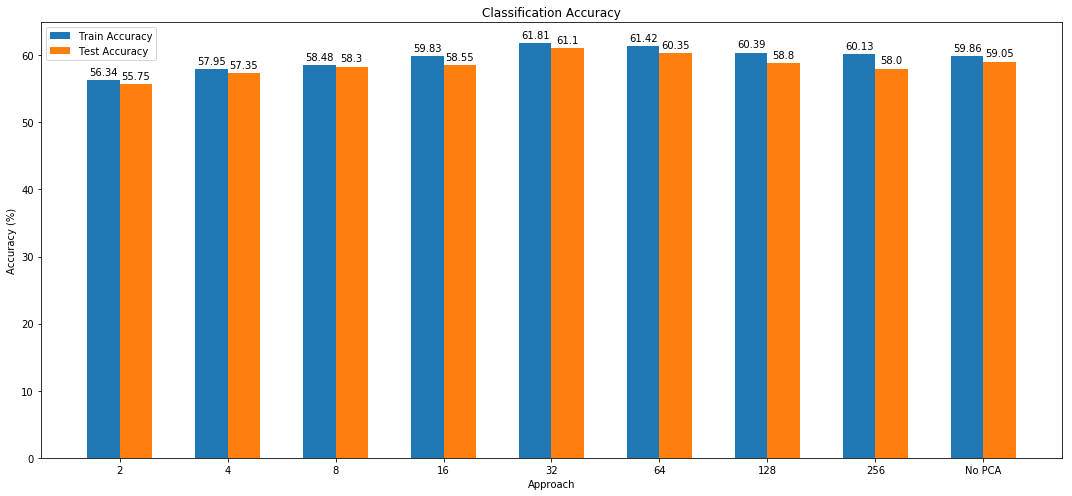

In [16]:
train = (flatten_images(CatDog_train_noisy), CatDog_train_targ)
test = (flatten_images(CatDog_test_noisy), CatDog_test_targ)

accuracy = []

k_s_9[-1] = None
for k in k_s_9:
    acc, _, _, _, _ = evaluate_clf(train, test, k)
    accuracy.append(acc)

display_results(accuracy, k_s_9)

### Question 3b

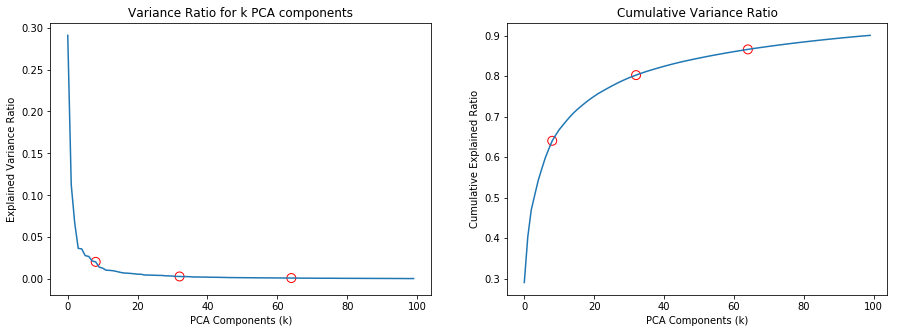

In [17]:
k_s = [8, 32, 64]

train_pca = PCA(n_components=100, svd_solver='randomized').fit(flatten_images(train_norm))
var_ratio = train_pca.explained_variance_ratio_

plot_explained_var(var_ratio, k_s)

Again, we chose a single value at the elbow and a few values further down the variance_ratio curve to ensure we take into account higher cumulative variance ration pca components.

### Question 3c

In [18]:
train = (flatten_images(train_norm), np.array(train_set_obj.targets))
test = (flatten_images(test_norm), np.array(test_set_obj.targets))

k_s_4 = np.append(k_s, None)

accuracy, times, conf_mat = [], [], []

logr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)
nb = GaussianNB()
    
for clf in [logr, nb]:
    for k in k_s_4:
        acc, _, _, t, cm = evaluate_clf(train, test, k)
        accuracy.append(acc), times.append(t), conf_mat.append(cm)

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [20]:
def to_tensor(data, transpose=True, batch_size=0):
    """ Transforms a numpy image into a tensor
        Also splits it into batches if over 0

    Parameters
    ----------
    data
        np.array of CIFAR10 data
    transpose : optional
        Should be set to True for images to transpose into correct form for network
    batch_size

    Returns
    -------
    data_tensor
        torch tensor

    """
    
    if transpose:
        data = np.transpose(data.copy(), (0, 3, 1, 2))
    
    if batch_size > 1:
        data_tensor = torch.tensor(data).split(batch_size)
    else:
        data_tensor = torch.tensor(data)
        
    return data_tensor

In [21]:
# Train the Convolutional Neural Network
batch = 4

batch_train = (to_tensor(train_norm, batch_size=batch), to_tensor(train_set_obj.targets, transpose=False, batch_size=batch))

net = Net().float()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

start_train = time.time()

for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i in range(len(batch_train[0])):
        
        inputs = batch_train[0][i]
        labels = batch_train[1][i]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

train_time = time.time() - start_train
print('Finished Training')

[1,  2000] loss: 2.073
[1,  4000] loss: 1.757
[1,  6000] loss: 1.606
[1,  8000] loss: 1.515
[1, 10000] loss: 1.504
[1, 12000] loss: 1.450
[2,  2000] loss: 1.403
[2,  4000] loss: 1.382
[2,  6000] loss: 1.325
[2,  8000] loss: 1.293
[2, 10000] loss: 1.308
[2, 12000] loss: 1.276
[3,  2000] loss: 1.247
[3,  4000] loss: 1.224
[3,  6000] loss: 1.192
[3,  8000] loss: 1.182
[3, 10000] loss: 1.197
[3, 12000] loss: 1.165
Finished Training


### Question 3d

In [22]:
# Make predictions:

train_step = 10000
train_pred = np.empty(train_norm.shape[0])
for i in range(0, train_norm.shape[0], train_step):
    out_train = net(to_tensor(train_norm[i:i+train_step]).float())
    train_pred[i:i+train_step] = np.argmax(out_train.detach().numpy(), axis=1)

    
start_test = time.time()
    
out_test = net(to_tensor(test_norm).float())
test_pred = np.argmax(out_test.detach().numpy(), axis=1)

test_time = time.time() - start_test

train_acc = calc_accuracy(train_pred, np.array(train_set_obj.targets))
test_acc = calc_accuracy(test_pred, np.array(test_set_obj.targets))

nn_acc = (train_acc, test_acc)
nn_times = (train_time, test_time)
nn_cm = metrics.confusion_matrix(np.array(test_set_obj.targets), test_pred)

Maximum test accuracy of 57.08% was achived for CNN
Average train accuracy is 36.1%
Average test accuracy is 35.7%


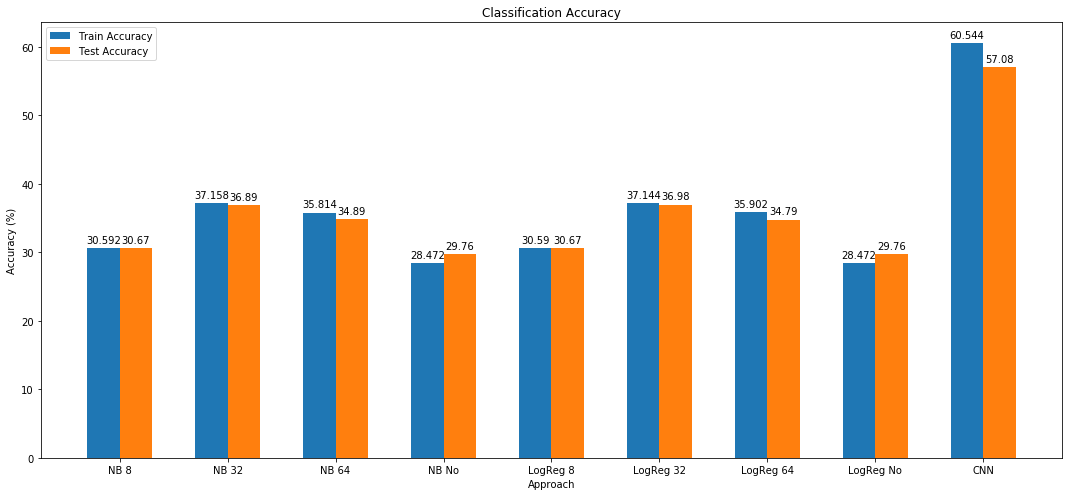

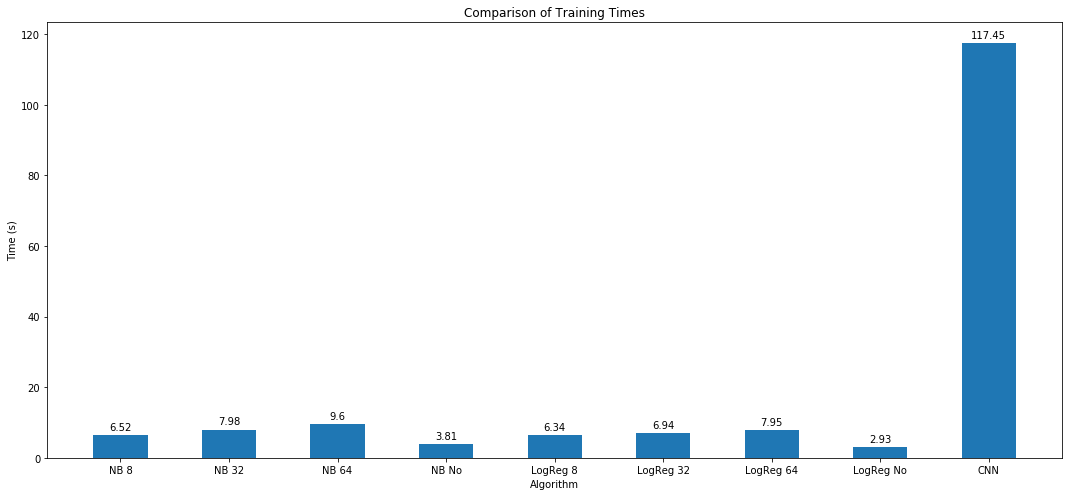

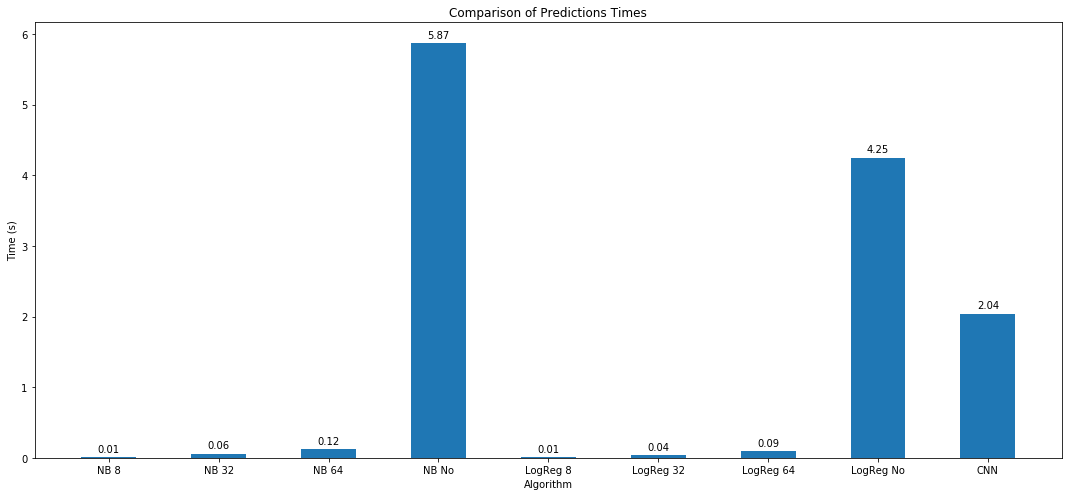

In [23]:
# Plot results:

all_acc = np.vstack([np.array(accuracy), np.array(nn_acc)])
all_times = np.vstack([np.array(times), np.array(nn_times)])
all_times = np.round(all_times, 2)

k_s_4[-1] = 'No'
nb_labels = [f'NB {str(i)}' for i in k_s_4]
logreg_labels = [f'LogReg {str(i)}' for i in k_s_4]

labels = nb_labels + logreg_labels + ['CNN']

display_results(all_acc, labels)

titels = ['Training', 'Predictions']
for i in range(all_times.shape[1]):
   bar_plot([all_times[:,i]], labels, bar_width=0.5, title=f'Comparison of {titels[i]} Times', xlabel='Algorithm', ylabel='Time (s)') 

### Question 3e

In [24]:
# Plot Confusion Matrix
def plot_conf_mat(cm, ax, title):
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set(xticks=[], yticks=[], title=title)

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = nn_cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

In [25]:
conf_mat.append(nn_cm)

Classes are ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] going up to down and left to right


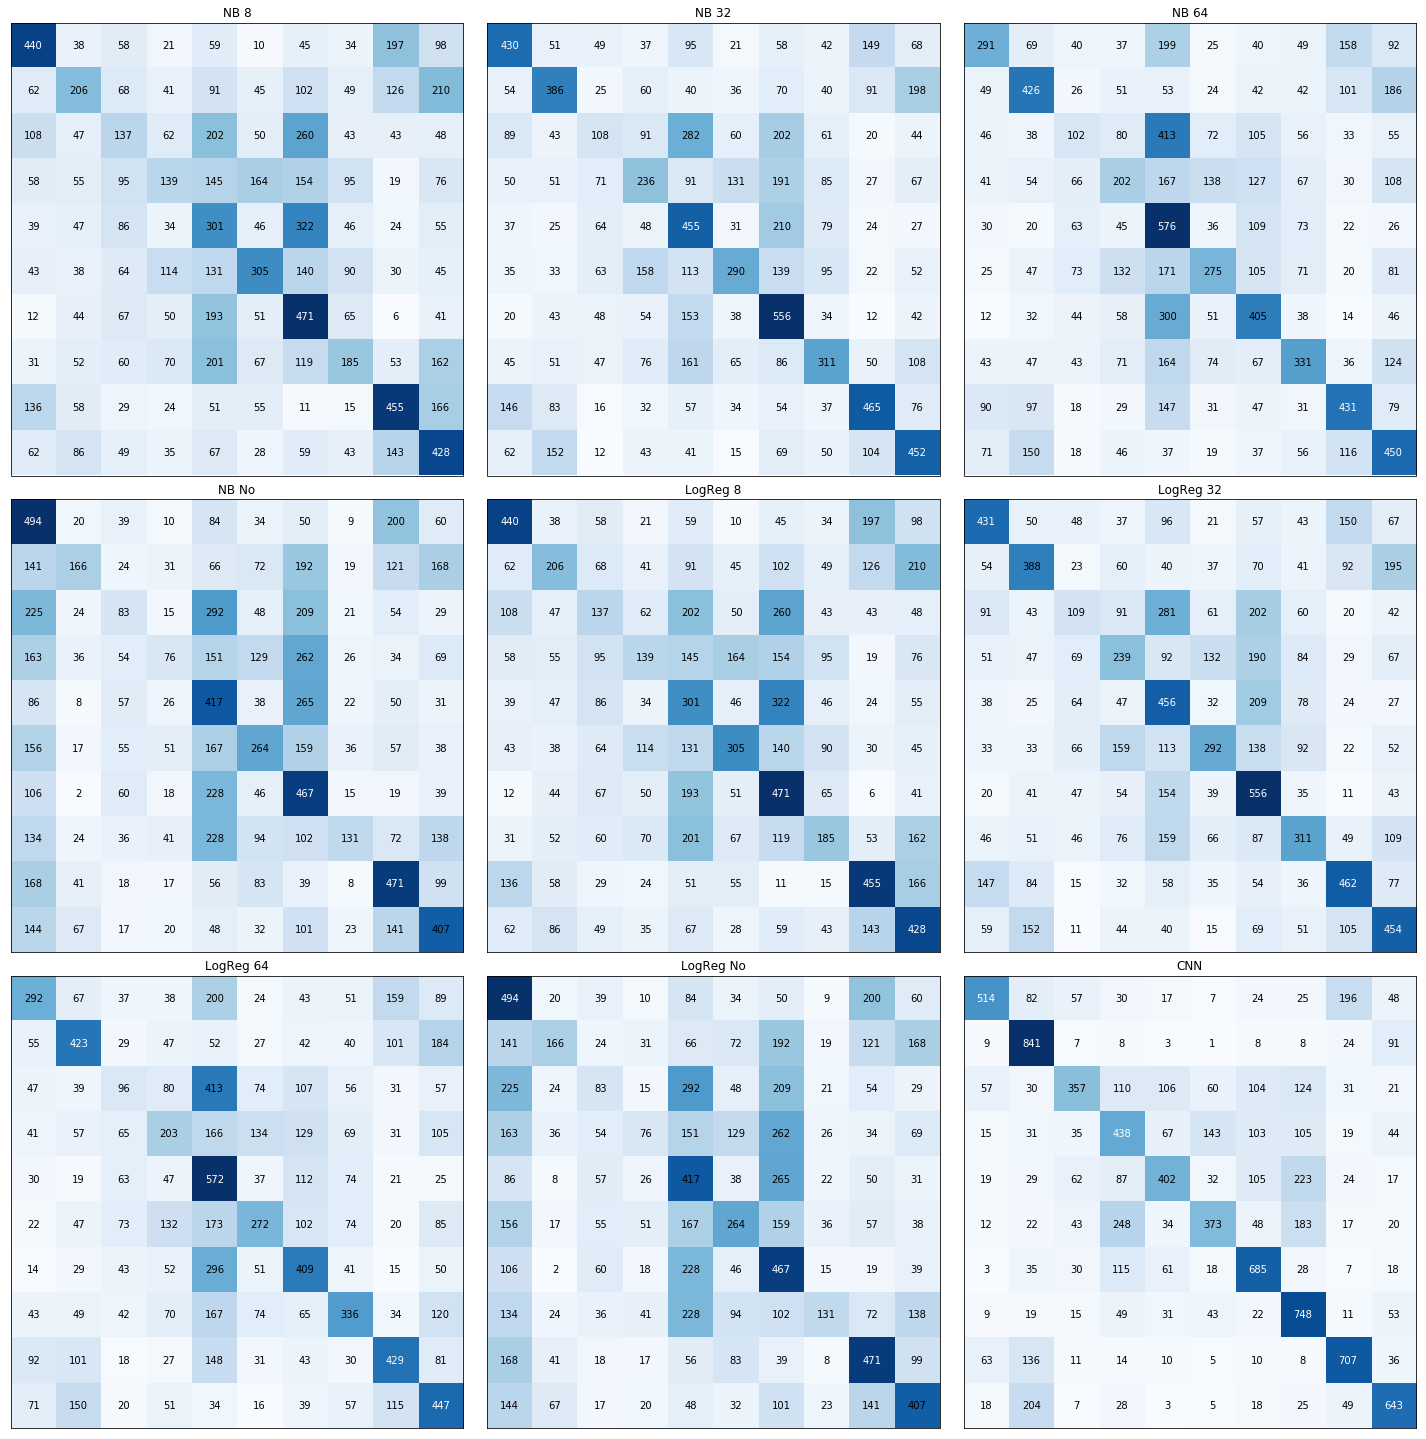

In [26]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))

n = 0
for i in range(3):
    for j in range(3):
        plot_conf_mat(conf_mat[n], ax[i][j], labels[n])
        n+=1

print(f'Classes are {train_set_obj.classes} going up to down and left to right')

### Question 3f

1.	Accuracies for Naïve Bayes correspond to those in the 2 class training where 32PCA components performed the best with 36.9% (when random classification would result in 10% accuracy).  Interestingly, for more classes it looks like classification without PCA performs relatively worth than for 2 classes highlighting its importance in multiclass classification. Logistic regression performed slightly better than Naïve Bayes with a high score of 37.0%. Such a small difference between those two could suggest that the naïve assumptions made for the dataset are at least partially correct. The CNN obviously performed much better with a test score of 57.1%. There are no signs of over fitting for all classifiers except for CNN suggesting that there might not be enough data to train well such a complex architecture. 

2.	The training times are all relatively low for both Naïve Bayes and Logistic Regression classifiers. Big portion of that time is dedicated to training and performing PCA which increases as we increase the number of components. CNN training time is much larger with almost 2min. This would increase further if we decide to train for more epochs to improve the performance. As for the prediction times, surprisingly both NB and LogReg classifiers take a very long time to predict when no PCA is used. In fact it takes longer to predict than to train…  The CNN prediction is relatively fast putting it at no disadvantage in that regard.

3.	Confusion matrices further confirm the clear outperformance of the CNN classifier.  There are a few particular classes that get misclassified.  It appears that for example in some classifiers, frog gets often misclassified as a bird or a deer. All those appear to be very similar looking causing constant misclassification. 

### Question 4: Denoising Autoencoder (4 marks)

This question uses both the original and noisy CIFAR-10 datasets (all 10 classes).

Read about denoising autoencoder at [Wikepedia](https://en.wikipedia.org/wiki/Autoencoder#Denoising_autoencoder_(DAE)) and this [short introduction](https://towardsdatascience.com/denoising-autoencoders-explained-dbb82467fc2) or any other sources you like.

4a. Modify the autoencoder architecture in Lab 7 so that it takes colour images as input (i.e., 3 input channels). 

4b. **Training**: feed the **noisy training images** as input to the autoencoder in 4a; use a loss function that computes the reconstruction error between the **output of the autoencoder** and the respective **original images**.

4c. **Testing**: evaluate the autoencoder trained in 4b on the test datasets (feed noisy images in and compute reconstruction errors on original clean images. Find the **worstly denoised** 30 images (those with the largest reconstruction errors) in the test set and show them in pairs with the original images (60 images to show in total).

4d. Choose at least two hyperparameters to vary. Study **at least three different choices** for each hyperparameter. When varying one hyperparameter, all the other hyperparameters can be fixed. Visualise the performance sensitivity with respect to these hyperparameters.

4e. Describe **at least two** interesting observations from the evaluation results above. Each observation should have **3-5 sentences**. 

### Question 4a

In [27]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # to range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Question 4b

In [28]:
def train_ae(train_in, train_out, batch_size=64, lr=0.001, n_epochs=2):

    ae_train = (to_tensor(train_in, batch_size=batch_size), to_tensor(train_out, batch_size=batch_size))

    AE = Autoencoder().float()

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(AE.parameters(), lr=lr, weight_decay=1e-5)

    for epoch in range(n_epochs):

        for i in range(len(ae_train[0])): 

            inputs = ae_train[0][i]
            labels = ae_train[1][i]

            optimizer.zero_grad()

            recon = AE(inputs.float())
            loss = criterion(recon, labels.float())
            loss.backward()
            optimizer.step()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
    
    return AE, outputs

In [29]:
# Prepare the data for autoencode: scale to be between 0..1 
train_in = np.clip(normalise(train_noisy, train_mean, train_std, reverse=True), 0, 1)
train_out = normalise(train_norm, train_mean, train_std, reverse=True)

In [30]:
AE, _ = train_ae(train_in, train_out)

Epoch:1, Loss:0.0089
Epoch:2, Loss:0.0069


### Question 4c

In [31]:
def display_pairs(inputs, outputs):
    
    n_examples = 10

    fig = plt.figure(figsize = (20, 30))
    outer = gridspec.GridSpec(1, 3, wspace=0.2, hspace=0.1)
    
    n = 0
    for i in range(3):
        inner = gridspec.GridSpecFromSubplotSpec(n_examples, 2, subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    
        for j in range(0, n_examples*2, 2):
            clear_ax = plt.Subplot(fig, inner[j])
            noisy_ax = plt.Subplot(fig, inner[j+1])

            clear_ax.set_axis_off()
            noisy_ax.set_axis_off()
            
            clear_img = inputs[n]
            noisy_img = outputs[n]
            clear_ax.imshow(np.clip(clear_img, 0, 1))
            noisy_ax.imshow(np.clip(noisy_img, 0, 1))

            fig.add_subplot(clear_ax)
            fig.add_subplot(noisy_ax)
            
            n+=1

    fig.show()

def evaluate_ae(AE, test_noisy, test, display=False):
    
    out_test = AE(to_tensor(test_noisy).float())  
    np_out = np.transpose(out_test.detach().numpy(), (0, 2, 3, 1))
    flat_out = flatten_images(np_out)
    flat_test = flatten_images(test)
    
    total_mse = metrics.mean_squared_error(flat_test, flat_out)
    
    if display:
        img_mse = np.empty(flat_out.shape[0])
        for i in range(flat_out.shape[0]):
            img_mse[i] = metrics.mean_squared_error(flat_test[i], flat_out[i])
         
        example_idx = np.argpartition(img_mse, -31)[-31:]
        display_pairs(np_out[example_idx], test[example_idx])
    
    return total_mse

D:\Anaconda\envs\MLAI\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


MSE for test is 0.0373


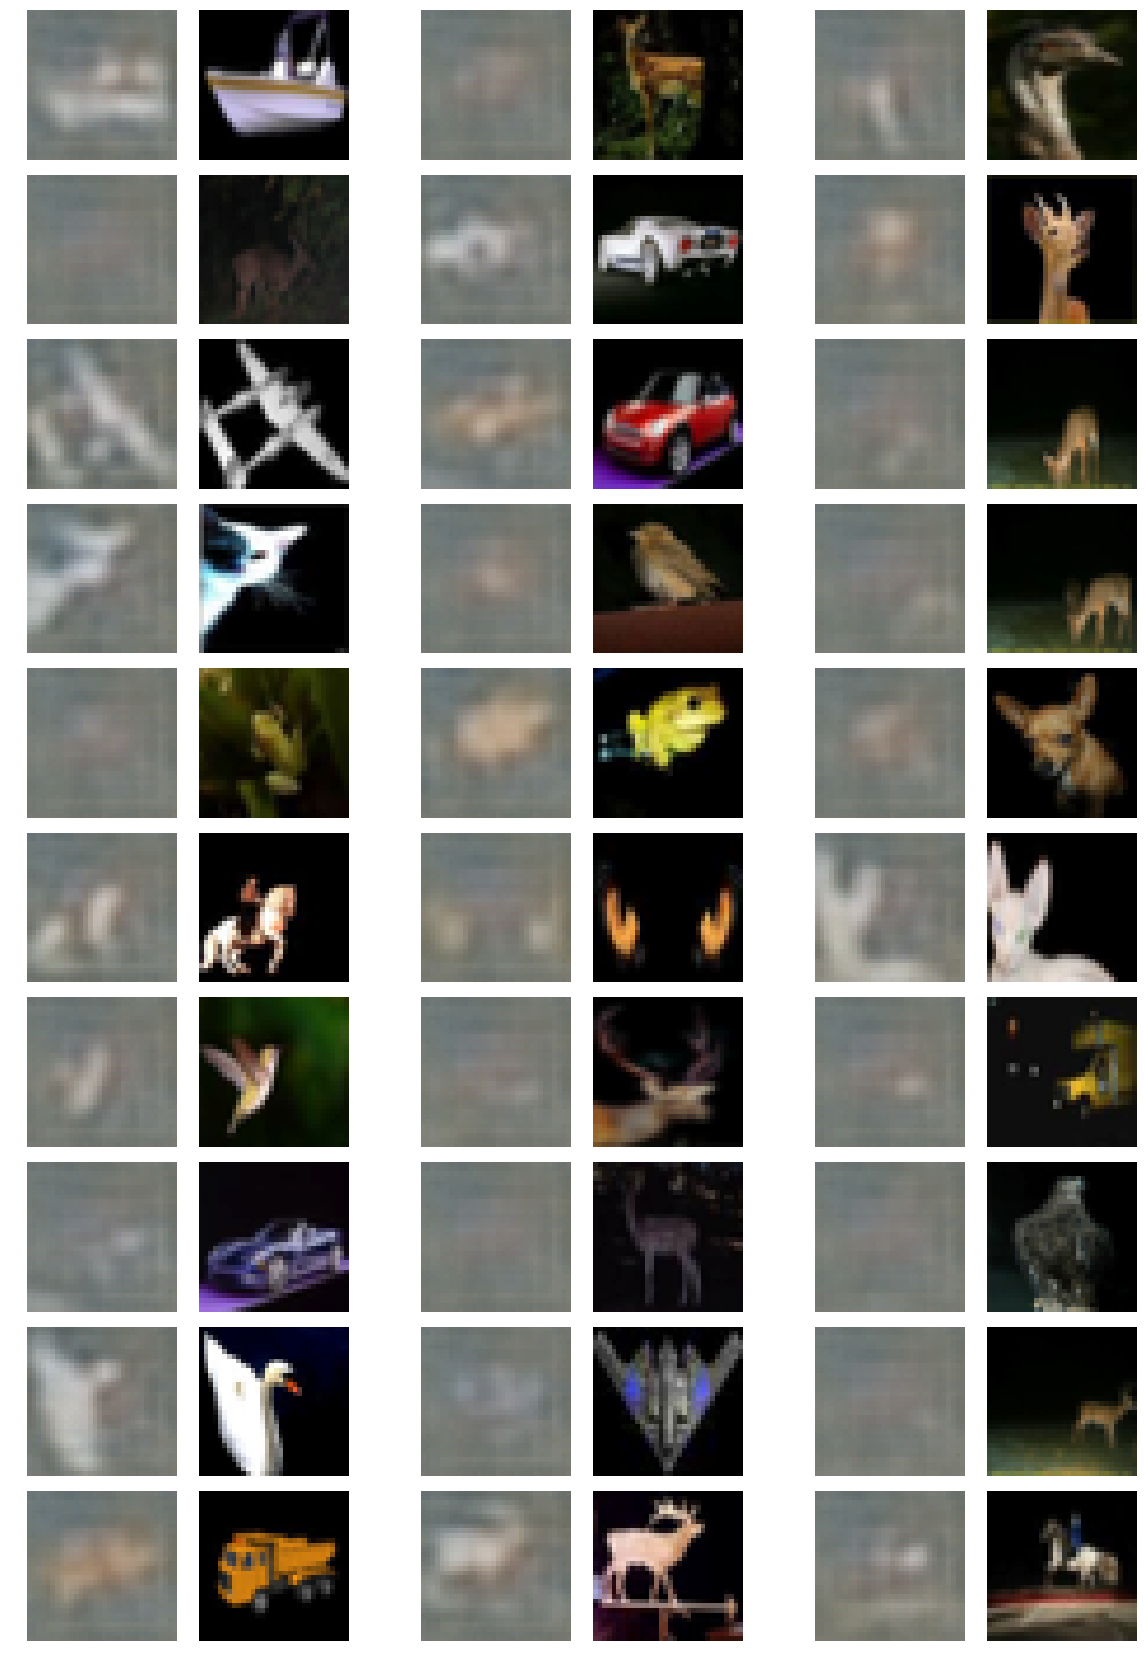

In [32]:
# Prepare the data for autoencode: scale to be between 0..1 
test_in = normalise(np.clip(test_noisy, 0, 1), train_mean, train_std, reverse=True)
test_out = normalise(test_norm, train_mean, train_std, reverse=True)

# Evaluate the autoecoder on the test set
mse = evaluate_ae(AE, test_in, test_out, display=True)
print(f'MSE for test is {mse:.3}')

### Question 4d

In [ ]:
# Testing different batch sizes:

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

batch_sizes = [16, 64, 128]

batch_results = []
for batch_size in batch_sizes:
    AE, _ = train_ae(train_in, train_out, batch_size=batch_size)
    ms = evaluate_ae(AE, test_in, test_out)
    batch_results.append(ms)
    
ax[0].plot(batch_sizes, batch_results)
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_xlabel('Batch Sizes')
    
opt_batch = batch_sizes[np.argmin(batch_results)]

# Testing different learning rates: 
lrs = [0.0005, 0.001, 0.01]

lr_results = []
for lr in lrs:
    AE, _ = train_ae(train_in, train_out, batch_size=opt_batch)
    ms = evaluate_ae(AE, test_in, test_out)
    lr_results.append(ms)
    
ax[1].plot(lrs, lr_results)
ax[1].set_ylabel('Loss (MSE)')
ax[1].set_xlabel('Learning Rates')

fig.show()

Epoch:1, Loss:0.0073
Epoch:2, Loss:0.0050


### Question 4e

1. From the images it appears that autoencoder is perofmirng very pourly. Notonly it doesn't remover noise it adds the tint which would only worthens the look of input (noisy) image. This is likely caused by a poor complexity of the network architecture and bad hyperparameter optimization. However, increasing the complexity of the netwrok might not be effective unless more data becomes availiable. There is so much variability in images meaning the task is very complex. In fact, the network is already masively overfitting where test error is around 5 times the train error.

2. Two parameters were chosen for optimization - batch_size and learning_rate. The original optimization was done on a larger test set, however to save time for marking only 3 key values were kept. The optimal batch size was found to be 8 and MSE would increase as batch size incerases or decreases to 16/4. Best learning rate was again 0.001 with larger learning rates sometimes perofrming well but often causing weight explosion. 

Note: The hyperparameter optimization for this was doen using just the train and test set. In reality this would have to be done using validation set and so would require to split the dataset further.